<a href="https://colab.research.google.com/github/JosephGrob/ISH_ressources_cours_ML/blob/main/Copie_de_TP02_regression_generalisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 2 : Régression et généralisation

Dans ce TP, nous allons voir comment :

* Ajuster une régression multiple "à la main" (avec numpy)
* Ajuster des modèles linéaires avec `sklearn`
* Sélectionner des hyperparmètres (un modèle) par cross-validation, puis estimer son erreur de généralisation.

Il y aura également un **exercice**, qui vous demendera d'effectuer vous-même une recherche d'hyperparamètres avec une regression Ridge, sur un nouveau jeu de données.

Pour ce TP, il nous faudra les librairies, modules et objets suivants

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Pour les modèles linéaires
from sklearn.linear_model import LinearRegression, Lasso, Ridge
# Pour séparer les datasets et la recherche des hyperparamètres
from sklearn.model_selection import train_test_split, GridSearchCV
# Pour faire des scores (l'opposé des fonctions de pertes) lisibles par sklearn
from sklearn.metrics import make_scorer

---

## Chargement et traitement des données

Commençons par définir le chemin à notre jeu de données "cancer_reg.csv" (https://github.com/Arnab777as3uj/STAT6021-Cancer-Prediction-Project) et chargeons le. Ce jeu de données contient de nombreuses variables concernant des localités aux États-Unis, avec en particulier la variable **TARGET_deathRate** contenant la mortalité moyenne par année (sur 100'000 habitants) due au cancer.

In [ ]:
file_path = "cancer_reg.csv"
# L'encodage du fichier est "latin-1"
data = pd.read_csv(file_path, encoding='latin-1')
data

,avgAnnCount,avgDeathsPerYear,TARGET_deathRate,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,"(45201, 48021.6]",44.2,...,54.9,44.6,31.7,13.2,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512
3043,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,"(48021.6, 51046.4]",30.4,...,53.3,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
3044,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,"(51046.4, 54545.6]",30.9,...,52.6,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192
3045,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,"(48021.6, 51046.4]",39.0,...,56.3,49.6,29.5,14.0,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938


Remarquons qu'il n'y a que des variables numériques, mis à part **binnedInc** (un intervalle) et **Geography** (nom de la ville) (voir `my_df.dtypes`). Les variables **incidenceRate**, **avgAnnCount**, **avgDeathsPerYear**, **popEst2015** sont des variables qui ont servi à la construction de la variable dépendante ou qui ne sont pas pertinentes. Nous allons enlever toutes ces variables :

In [ ]:
data = data.drop(["binnedInc", "Geography", "incidenceRate", "avgAnnCount",
                  "avgDeathsPerYear", "popEst2015"], axis=1)

In [ ]:
data

,TARGET_deathRate,medIncome,povertyPercent,studyPerCap,MedianAge,MedianAgeMale,MedianAgeFemale,AvgHouseholdSize,PercentMarried,PctNoHS18_24,...,PctPrivateCoverageAlone,PctEmpPrivCoverage,PctPublicCoverage,PctPublicCoverageAlone,PctWhite,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate
0,164.9,61898,11.2,499.748204,39.3,36.9,41.7,2.54,52.5,11.5,...,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,161.3,48127,18.6,23.111234,33.0,32.2,33.7,2.34,44.5,6.1,...,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,174.7,49348,14.6,47.560164,45.0,44.0,45.8,2.62,54.2,24.0,...,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,194.8,44243,17.1,342.637253,42.8,42.2,43.4,2.52,52.7,20.2,...,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,144.4,49955,12.5,0.000000,48.3,47.8,48.9,2.34,57.8,14.9,...,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,149.6,46961,12.4,0.000000,44.2,41.1,48.8,2.08,51.0,20.9,...,54.9,44.6,31.7,13.2,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512
3043,150.1,48609,18.8,377.175494,30.4,29.3,31.4,2.90,52.6,26.7,...,53.3,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
3044,153.9,51144,15.0,1968.959926,30.9,30.5,31.2,3.04,54.8,19.7,...,52.6,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192
3045,175.0,50745,13.3,0.000000,39.0,36.9,40.5,2.56,58.8,10.9,...,56.3,49.6,29.5,14.0,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938


Notre jeu de données possède des valeurs manquantes (`NaN`). Certaines instances de méthodes permettent de les prendre en charge, mais ici, nous allons les remplacer par la moyenne de la variable manquante. Pour cela, nous créons un dictionnaire contenant les moyennes des variables, puis on utilise `fillna`

In [ ]:
var_means = {var_name : data[var_name].mean() for var_name in data.columns}
data = data.fillna(value=var_means)
var_means

{'TARGET_deathRate': 178.66406301279943,
 'medIncome': 47063.28191663932,
 'povertyPercent': 16.87817525434854,
 'studyPerCap': 155.3994153176078,
 'MedianAge': 45.27233344273055,
 'MedianAgeMale': 39.57072530357729,
 'MedianAgeFemale': 42.14532326878897,
 'AvgHouseholdSize': 2.4796617984903184,
 'PercentMarried': 51.773679028552685,
 'PctNoHS18_24': 18.224450278962916,
 'PctHS18_24': 35.00206760748277,
 'PctSomeCol18_24': 40.977034120734906,
 'PctBachDeg18_24': 6.158286839514276,
 'PctHS25_Over': 34.80466032162783,
 'PctBachDeg25_Over': 13.282015096816542,
 'PctEmployed16_Over': 54.15264248704664,
 'PctUnemployed16_Over': 7.852412208729898,
 'PctPrivateCoverage': 64.35493928454217,
 'PctPrivateCoverageAlone': 48.45377358490566,
 'PctEmpPrivCoverage': 41.19632425336397,
 'PctPublicCoverage': 36.25264194289465,
 'PctPublicCoverageAlone': 19.240072202166065,
 'PctWhite': 83.6452862348999,
 'PctBlack': 9.107977614569412,
 'PctAsian': 1.2539649641860848,
 'PctOtherRace': 1.9835230038171974

Finalement, nous allons isoler notre variable dépendante des autres variables, et sauvegarder le nombre d'individus et variables dépendantes

In [ ]:
outputs = data["TARGET_deathRate"]
inputs = data.drop(["TARGET_deathRate"], axis=1)
n_row, n_col = inputs.shape

---

## Régression linéaire avec `numpy`

Nous allons faire ici une régression linéaire "à la main", à l'aide la la libraire `numpy`. Ainsi, nous pourrons comparer ces résultats avec ceux obtenus grâce à `sklearn`. Tout d'abord, on transforme nos entrées et sorties en Arrays

In [ ]:
inputs_a = inputs.to_numpy()
outputs_a = outputs.to_numpy()

Pour que nous puissons calculer l'intercept $w_0$, nous allons devoir ajouter une colonne de $1$ à nos entrées

In [ ]:
vec_of_ones = np.ones([n_row, 1])
x_matrix = np.concatenate([vec_of_ones, inputs_a], axis=1)
x_matrix

array([[1.00000000e+00, 6.18980000e+04, 1.12000000e+01, ...,
        1.84347853e+00, 5.28560759e+01, 6.11883103e+00],
       [1.00000000e+00, 4.81270000e+04, 1.86000000e+01, ...,
        3.74135153e+00, 4.53725004e+01, 4.33309558e+00],
       [1.00000000e+00, 4.93480000e+04, 1.46000000e+01, ...,
        2.74735831e+00, 5.44448684e+01, 3.72948782e+00],
       ...,
       [1.00000000e+00, 5.11440000e+04, 1.50000000e+01, ...,
        5.68070519e+00, 5.51539491e+01, 7.80919168e+00],
       [1.00000000e+00, 5.07450000e+04, 1.33000000e+01, ...,
        2.13179047e+00, 5.84842319e+01, 7.58293839e+00],
       [1.00000000e+00, 4.11930000e+04, 1.39000000e+01, ...,
        1.35645744e+00, 5.60402421e+01, 8.98172324e+00]])

Effectuons maintenant la formule de régression $\textbf{w} = (\textbf{X}^\top \textbf{X})^{-1}\textbf{X}^\top \textbf{y}$ pour trouver les coefficients $\textbf{w}$

In [ ]:
coef = np.linalg.inv(x_matrix.T @ x_matrix) @ x_matrix.T @ outputs_a
coef

array([ 2.19718691e+02,  2.19788004e-04,  2.77273746e-01,  9.31363532e-04,
        1.85557211e-03, -4.98272280e-01, -3.99391598e-01, -5.67544728e-01,
        1.47435223e+00, -2.00329540e-01,  2.92050344e-01,  5.19175769e-02,
       -8.22649608e-02,  5.30738029e-01, -1.39614877e+00, -5.63257056e-01,
        5.43905976e-01, -1.31379589e-01,  1.08845666e-01,  4.91756992e-01,
       -1.20887731e-01,  8.85889619e-01, -7.62392584e-02,  3.44733561e-02,
       -2.14858389e-01, -1.29052962e+00, -1.75472216e+00, -1.32999581e+00])

Calculons maintenant les prédictions et la $MSE$

In [ ]:
outputs_pred = x_matrix @ coef
mse = np.mean((outputs_pred - outputs_a)**2)
mse

458.43606876316204

Nous allons comparer ces résultats avec ceux obtenus avec `sklearn`.

---

## Régression linéaire avec `sklearn`

Le fonctionnnement usuel de méthodes dans `sklearn` se passe selon les étapes suivantes :

* On crée une instance de la classe de la méthode désirée (ici `LinearRegression`)
* On fait appelle à la méthode de l'objet `fit`, où l'on fait passer nos données. Cette méthode permet d'entrainer la méthode et trouver les paramètres optimaux.
* L'instance initiale va maintenant contenir toutes les informations relative à la méthode, que l'on peut extraire.

L'entrainement se fait donc de la manière suivante

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(inputs, outputs)

LinearRegression()

Puis on peut extraire l'intercept

In [ ]:
linear_reg.intercept_

219.7186906539548

ou les coefficients

In [ ]:
linear_reg.coef_

array([ 2.19788004e-04,  2.77273746e-01,  9.31363532e-04,  1.85557211e-03,
       -4.98272280e-01, -3.99391598e-01, -5.67544728e-01,  1.47435223e+00,
       -2.00329540e-01,  2.92050344e-01,  5.19175769e-02, -8.22649608e-02,
        5.30738029e-01, -1.39614877e+00, -5.63257056e-01,  5.43905976e-01,
       -1.31379589e-01,  1.08845666e-01,  4.91756992e-01, -1.20887731e-01,
        8.85889619e-01, -7.62392584e-02,  3.44733561e-02, -2.14858389e-01,
       -1.29052962e+00, -1.75472216e+00, -1.32999581e+00])

Comparons avec le résultat obtenu avec `numpy`

In [ ]:
coef - np.append(linear_reg.intercept_, linear_reg.coef_)

array([-1.20110144e-10, -4.58861464e-16, -5.91637850e-13, -1.03660570e-15,
       -6.45620710e-15,  2.78665979e-14,  8.05966405e-13,  1.53578261e-11,
       -2.82662782e-13,  1.45855550e-13, -2.22044605e-16, -5.07920095e-13,
       -2.77347589e-13, -2.24598118e-13, -9.39248679e-14,  2.27706742e-13,
        7.13540338e-13,  1.66316960e-12, -6.94194702e-13, -3.11695114e-13,
       -1.48336898e-12,  1.74227299e-12,  1.64521174e-13,  4.49085213e-14,
        1.20570220e-13,  4.27213820e-13, -1.65423231e-13,  2.52908805e-13])

on voit que les résultats sont similaires. Qu'en est-il des prédictions et de la $MSE$ ?

In [ ]:
sk_outputs_pred = linear_reg.predict(inputs)
sk_mse = np.mean((sk_outputs_pred - outputs)**2)
print(f"MSE numpy = {mse}, MSE sklearn = {sk_mse}")

MSE numpy = 458.43606876316204, MSE sklearn = 458.43606876316204


L'erreur est quasiment identique et on peut être rassuré sur les capacités de `sklearn` ! Pour plus d'information sur `LinearRegression`, voir https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html.

---

## La sélection des hyperparamètres pour une regression *Lasso* par cross-validation

Dans les parties précédentes, nous avons utilisé toutes les variables du jeux de données. Ici, grâce à une régression régularisée de type *Lasso* (L1), nous allons voir si certaines variables peuvent être omises. Pour cela, nous allons définir un paramètre optimal $\lambda$ par cross-validation, et évaluer le modèle retenu.

On commence par scinder aléatoirement le jeu de données en deux, avec d'un côte le jeu de données entrainement/validation (servant à la cross-validation), et de l'autre le jeu de test. La taille du jeu de test est posée à 20%. Nous pouvons utiliser pour cela la fonction `train_test_split` de `sklearn.model_selection`

In [ ]:
inputs_train_val, inputs_test, outputs_train_val, outputs_test = \
    train_test_split(inputs, outputs, test_size=0.2)
# On sauvegarde les tailles
n_row_train_val = inputs_train_val.shape[0]
n_row_test = inputs_test.shape[0]
n_row_test

610

Posons maintenant les valeurs de $\lambda$ qui vont être testées (50 valeurs entre 0.001 et 1, la valeur 0 ne fonctionne pas bien avec Lasso de `sklearn`), ainsi que le nombre de folds $k$

In [ ]:
hyp_lambdas = np.linspace(0.001, 1, 50)
k = 5
hyp_lambdas

array([0.001     , 0.02138776, 0.04177551, 0.06216327, 0.08255102,
       0.10293878, 0.12332653, 0.14371429, 0.16410204, 0.1844898 ,
       0.20487755, 0.22526531, 0.24565306, 0.26604082, 0.28642857,
       0.30681633, 0.32720408, 0.34759184, 0.36797959, 0.38836735,
       0.4087551 , 0.42914286, 0.44953061, 0.46991837, 0.49030612,
       0.51069388, 0.53108163, 0.55146939, 0.57185714, 0.5922449 ,
       0.61263265, 0.63302041, 0.65340816, 0.67379592, 0.69418367,
       0.71457143, 0.73495918, 0.75534694, 0.77573469, 0.79612245,
       0.8165102 , 0.83689796, 0.85728571, 0.87767347, 0.89806122,
       0.91844898, 0.93883673, 0.95922449, 0.97961224, 1.        ])

Nous tirons maintenant aléatoirement les attributions des individus dans les folds (sur le jeu d'entrainement/validation)

de moi : """""""""""""""""""2"La phrase explique que, dans le cadre de la validation croisée, on attribue de manière aléatoire chaque observation (chaque individu) à un des folds. Cela se fait afin de répartir les données de manière équilibrée et sans biais entre les différentes parties (folds) de votre validation croisée, où certains folds seront utilisés pour l'entraînement, et d'autres pour la validation, au cours de chaque itération de l'évaluation du modèle."

Dans une validation croisée (cross-validation), l’idée principale est de diviser les données d’une manière telle que le modèle puisse être évalué plusieurs fois sur différentes portions des données. Typiquement, cela peut se faire soit sur l’ensemble des données disponibles (ensemble complet), soit sur un sous-ensemble, comme l'ensemble d’entraînement dans le cadre d’une approche avec jeu de test séparé.

Dans le contexte que vous mentionnez, la validation croisée se fait probablement uniquement sur les données d’entraînement si vous avez un pipeline classique d’entraînement et de test des modèles.
Approche classique : Validation croisée uniquement sur les données d'entraînement

Voici un schéma typique :

    Séparation des données : Vous commencez par diviser votre jeu de données en deux parties :
        Ensemble d’entraînement (training set).
        Ensemble de test (test set).

    L’ensemble de test est généralement mis de côté et n'est utilisé qu'à la toute fin pour évaluer les performances du modèle final.

    Validation croisée sur l'ensemble d'entraînement : Ensuite, vous appliquez la validation croisée uniquement sur l'ensemble d'entraînement. L’objectif est de trouver le meilleur modèle ou de régler ses hyperparamètres (comme le choix de la régularisation, la profondeur d'un arbre de décision, etc.). Pour ce faire, vous divisez l’ensemble d’entraînement en k sous-ensembles (folds), en itérant pour entraîner le modèle sur k−1k−1 folds et le tester sur le fold restant à chaque itération.

    À chaque itération, un sous-ensemble différent est utilisé pour la validation, et les autres pour l’entraînement. Cela permet d’évaluer les performances du modèle sur l’ensemble d’entraînement de manière plus robuste.

Avantages de cette approche :

    Le modèle est optimisé et évalué sur l’ensemble d'entraînement, mais il ne voit jamais les données de test avant la fin.
    Cela permet d’éviter le surapprentissage et d’évaluer correctement les performances du modèle sur des données non vues.

Pourquoi ne pas inclure l'ensemble de test dans la validation croisée ?

    Si vous incluez l’ensemble de test dans la validation croisée, vous « ferez fuir » de l’information sur les performances du modèle pendant l’entraînement, ce qui pourrait biaiser l’évaluation du modèle.
    Le test final sur l’ensemble de test séparé est nécessaire pour donner une estimation réelle des performances du modèle sur des données qu'il n'a jamais vues (ce qui est plus proche du comportement du modèle dans un environnement réel).

Cas où la validation croisée est faite sur l'ensemble complet :

Il est possible de faire de la validation croisée sur l'ensemble complet des données lorsque vous n’avez pas de jeu de test séparé. Cela peut se faire, par exemple, dans le cadre d'un petit jeu de données ou quand vous souhaitez maximiser l’utilisation de toutes vos données disponibles pour la validation. Cela permet d'utiliser chaque observation à la fois pour l'entraînement et la validation. Cependant, cela n'est généralement pas recommandé pour évaluer la généralisation finale du modèle.
Conclusion

Dans votre cas, si vous suivez une approche standard :

    La validation croisée se fait uniquement sur les données d'entraînement.
    L'ensemble de test est laissé de côté pour évaluer le modèle après la validation croisée et l'entraînement final.

Cela garantit une bonne évaluation des performances du modèle sur des données qu’il n’a jamais vues pendant la phase d'entraînement"""""""""""""""""""""""

In [ ]:
# Un vecteur contenant 0, 1, 2, ..., k répèté assez de fois pour
# dépasser n_row_train_val
fold_membs = np.tile(np.arange(k), int(np.ceil(n_row_train_val / k)))
# On ne garde que les n_row_train_val premiers éléments
fold_membs = fold_membs[:n_row_train_val]
# On mélange le vecteur
np.random.shuffle(fold_membs)

Passons maintenant aux boucles formant le coeur de la cross-validation. La boucle extérieure va tester toutes les valeurs de $\lambda$, et pour chaque valeur, la boucle intérieure va entrainer et valider un modèle selon les folds.
Les résultats finaux de cette double boucle sont deux listes contenant les valeurs moyennes de $MSE_\text{train}$ et $MSE_\text{valid}$ pour chaque $\lambda$.

In [ ]:
# Pour stocker la moyenne du mse pour chaque paramètre
train_mse_means, val_mse_means = [], []

# Boucle sur les lambdas
for hyp_lambda in hyp_lambdas:

  # Pour stocker la valeur du mse sur chaque fold
  train_mses, val_mses = [], []

  # Boucle sur les folds
  for fold in range(k):

    # On trouve les indices des folds
    indices_train = np.where(fold_membs != fold)[0]
    indices_val = np.where(fold_membs == fold)[0]

    # On sépare le jeu en 2 groupes : entrainement - validation
    inputs_train = inputs_train_val.iloc[indices_train, ]
    inputs_val = inputs_train_val.iloc[indices_val, ]
    outputs_train = outputs_train_val.iloc[indices_train]
    outputs_val = outputs_train_val.iloc[indices_val]

    # On entraine le modèle ("alpha" est le paramètre de régularisation)
    lasso_reg = Lasso(alpha=hyp_lambda)
    lasso_reg.fit(inputs_train, outputs_train)

    # On calcule la train_mse et val_mse
    train_mse = np.mean((lasso_reg.predict(inputs_train) - outputs_train)**2)
    val_mse = np.mean((lasso_reg.predict(inputs_val) - outputs_val)**2)

    # On sauve les valeurs
    train_mses.append(train_mse)
    val_mses.append(val_mse)

  # On sauve les moyennes sur les folds
  train_mse_means.append(np.mean(train_mses))
  val_mse_means.append(np.mean(val_mses))

Observons comment varient $MSE_\text{train}$ et $MSE_\text{valid}$ en fonction de $\lambda$

[]

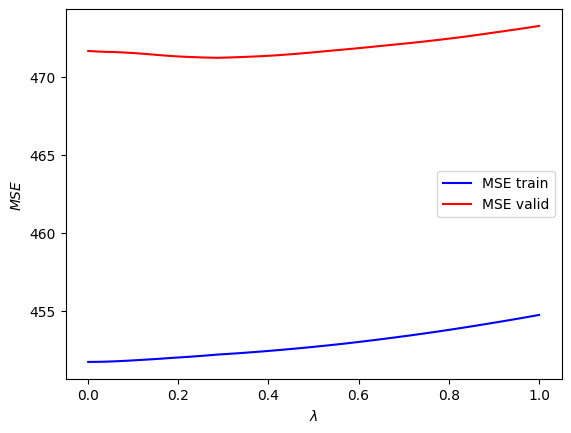

In [ ]:
fig, ax = plt.subplots()
ax.plot(hyp_lambdas, train_mse_means, c="blue", label="MSE train")
ax.plot(hyp_lambdas, val_mse_means, c="red", label="MSE valid")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("$MSE$")
ax.legend()
plt.plot()

On peut trouver la valeur optimale l'hyperparmètre $\lambda$ avec

In [ ]:
index_opt_hyp_lambda = np.where(val_mse_means == min(val_mse_means))[0][0]
opt_hyp_lambda = float(hyp_lambdas[index_opt_hyp_lambda])
print(f"La valeur optimale de lambda est : {opt_hyp_lambda}")

La valeur optimale de lambda est : 0.2864285714285714


On peut donc maintenant calculer l'erreur de généralisation sur le jeu de test

In [ ]:
# On entraine le modèle sur toutes les données d'entrainement - validation
opt_lasso_reg = Lasso(alpha=opt_hyp_lambda)
opt_lasso_reg.fit(inputs_train_val, outputs_train_val)
# On calcul l'erreur
test_mse_lasso = np.mean((opt_lasso_reg.predict(inputs_test) - outputs_test)**2)
test_mse_lasso

482.36646523159743

Si l'on la compare à la régression linéaire "classique"

In [ ]:
# On entraine le modèle sur toutes les données d'entrainement - validation
lin_reg = LinearRegression()
lin_reg.fit(inputs_train_val, outputs_train_val)
# On calcul l'erreur
test_mse_lin = np.mean((lin_reg.predict(inputs_test) - outputs_test)**2)
test_mse_lin

484.37943554258317

On voit que les prédictions sont (normalement et légèrement) meilleures. Que valent nos coefficients ?

In [ ]:
reg_coef = np.append(lin_reg.intercept_, lin_reg.coef_)
lasso_coef = np.append(opt_lasso_reg.intercept_, opt_lasso_reg.coef_)
pd.DataFrame({"Variables" : ["intercept"] + list(inputs.columns),
              "Coefficient Reg": reg_coef,
             "Coefficient Lasso": lasso_coef})

,Variables,Coefficient Reg,Coefficient Lasso
0,intercept,216.619698,211.093583
1,medIncome,0.000242,0.000198
2,povertyPercent,0.401720,0.368734
3,studyPerCap,0.001086,0.001059
4,MedianAge,0.011694,0.011215
5,MedianAgeMale,-0.834412,-0.769150
6,MedianAgeFemale,-0.112665,-0.093752
7,AvgHouseholdSize,-1.092080,-0.000000
8,PercentMarried,1.504254,1.351531
9,PctNoHS18_24,-0.223624,-0.216908


On voit que certains ont été annulés, d'autres sont très faibles et la pluparts (mais pas forcement tous) ont été réduits. L'annulation de certains coefficients est typique de la régression Lasso.

---

## La sélection des hyperparamètres avec `sklearn`

La libraire `sklearn` offre une interface qui permet d'effectuer la recherche de paramètre optimaux via une cross-validation. Le code est beaucoup plus compact ainsi (pour plus de détails, voir https://scikit-learn.org/stable/modules/grid_search.html#grid-search)

La différence majeure avec cette nouvelle approche utilisant GridSearchCV de sklearn réside dans la manière dont le processus de sélection d’hyperparamètres et de validation croisée est géré de manière plus automatisée et compacte par la bibliothèque scikit-learn. Revenons point par point sur ce qui change par rapport à votre implémentation manuelle précédente, et ce que fait cette nouvelle approche avec GridSearchCV.
Ce qui est différent avec GridSearchCV dans sklearn
1. Automatisation de la validation croisée et de la recherche d’hyperparamètres

Dans le code précédent, vous avez implémenté manuellement :

    La boucle sur les valeurs de λλ (le paramètre de régularisation).
    La boucle sur les folds pour effectuer la validation croisée.
    Le calcul manuel des erreurs quadratiques moyennes (MSE) pour chaque fold.

Avec GridSearchCV, toutes ces étapes sont gérées automatiquement par scikit-learn. Il n’est plus nécessaire de coder explicitement les boucles sur les hyperparamètres et les folds, car GridSearchCV combine la validation croisée et la recherche d’hyperparamètres de manière intégrée.
2. Sélection des hyperparamètres à tester via un dictionnaire

Au lieu de faire une boucle manuelle sur les différentes valeurs de λλ comme dans votre premier code, vous pouvez simplement passer les hyperparamètres à explorer dans un dictionnaire

In [ ]:
# On doit entrer les différents hyperparamètres à tester dans un dictionnaire
# Ici, il n'y a que "alpha"
param_dict = {"alpha": hyp_lambdas}

# On construit une fonction pour notre perte. Sinon, sklearn utilise la fonction
# de "score" par défaut contenu dans la méthode utilisée
def mse_loss(y_true, y_pred):
  return np.mean((y_true - y_pred)**2)

# On transforme cette fonction de perte (petit est meilleur) fonction de score
# (grand est meilleur), ainsi que dans une fonction lisible par sklearn
mse_score = make_scorer(mse_loss, greater_is_better=False)

# La recherche des paramètres s'effectue ainsi
lasso = Lasso()
gride_search = GridSearchCV(lasso,
                            param_dict,
                            scoring=mse_score,
                            cv=k,
                            return_train_score=True)
gride_search.fit(inputs_train_val, outputs_train_val)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([0.001     , 0.02138776, 0.04177551, 0.06216327, 0.08255102,
       0.10293878, 0.12332653, 0.14371429, 0.16410204, 0.1844898 ,
       0.20487755, 0.22526531, 0.24565306, 0.26604082, 0.28642857,
       0.30681633, 0.32720408, 0.34759184, 0.36797959, 0.38836735,
       0.4087551 , 0.42914286, 0.44953061, 0.46991837, 0.49030612,
       0.51069388, 0.531081...0.55146939, 0.57185714, 0.5922449 ,
       0.61263265, 0.63302041, 0.65340816, 0.67379592, 0.69418367,
       0.71457143, 0.73495918, 0.75534694, 0.77573469, 0.79612245,
       0.8165102 , 0.83689796, 0.85728571, 0.87767347, 0.89806122,
       0.91844898, 0.93883673, 0.95922449, 0.97961224, 1.        ])},
             return_train_score=True,
             scoring=make_scorer(mse_loss, greater_is_better=False, response_method='predict'))

{'alpha': 0.4699183673469388}


[]

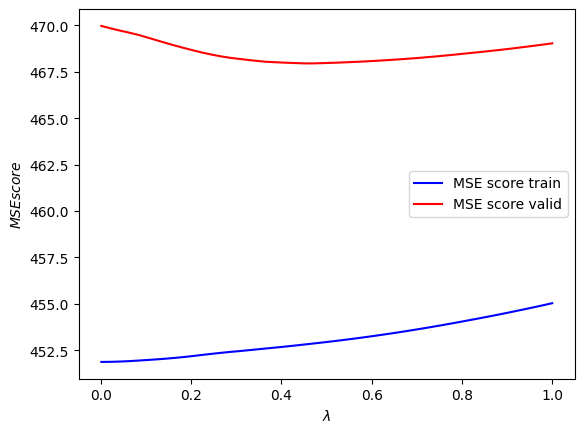

In [ ]:
# Pour sortir le meilleur paramètre
print(gride_search.best_params_)
# Les différents scores sont là
train_score = gride_search.cv_results_["mean_train_score"]
val_score = gride_search.cv_results_["mean_test_score"]
# Le graphique
fig, ax = plt.subplots()
ax.plot(hyp_lambdas, -train_score, c="blue", label="MSE score train")
ax.plot(hyp_lambdas, -val_score, c="red", label="MSE score valid")
ax.set_xlabel("$\lambda$")
ax.set_ylabel("$MSE score$")
ax.legend()
plt.plot()

---

## Exercice : recherche d'hyperparamètres avec une regression Ridge, sur le dataset *winequality*

Vous avez à disposition deux jeux de données sur les vins : **winequality-red.csv** et **winequality-white.csv**. Ces deux jeux contiennent plusieurs variables concernant la composition des vins, et un score dénotant sa qualité

In [ ]:
file_path = "winequality-red.csv"
# Pour les blancs
#file_path = "winequality-white.csv"
wine_data = pd.read_csv(file_path, sep=";")
wine_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [ ]:
#séparer notre jeu de données en variables dépendante et indépendante (output)

outputs_wine = wine_data["quality"]
inputs_wine = wine_data.drop(["quality"], axis=1)
n_row_wine, n_col_wine = inputs.shape


In [ ]:
#séparer nos input et output en training et validation
inputs_train_wine_val, inputs_test_wine, outputs_train_wine_val, outputs_test_wine = \
    train_test_split(inputs_wine, outputs_wine, test_size=0.2)
# On sauvegarde les tailles
n_row_train_wine_val = inputs_train_wine_val.shape[0]
n_row_test_wine = inputs_test_wine.shape[0]
n_row_test_wine

320

In [ ]:
#posons maintenant les lambda qui vont être testé
hyp_lambdas_wine = np.linspace(0.001, 0.3, 50)
k = 5
hyp_lambdas_wine

array([0.001     , 0.00710204, 0.01320408, 0.01930612, 0.02540816,
       0.0315102 , 0.03761224, 0.04371429, 0.04981633, 0.05591837,
       0.06202041, 0.06812245, 0.07422449, 0.08032653, 0.08642857,
       0.09253061, 0.09863265, 0.10473469, 0.11083673, 0.11693878,
       0.12304082, 0.12914286, 0.1352449 , 0.14134694, 0.14744898,
       0.15355102, 0.15965306, 0.1657551 , 0.17185714, 0.17795918,
       0.18406122, 0.19016327, 0.19626531, 0.20236735, 0.20846939,
       0.21457143, 0.22067347, 0.22677551, 0.23287755, 0.23897959,
       0.24508163, 0.25118367, 0.25728571, 0.26338776, 0.2694898 ,
       0.27559184, 0.28169388, 0.28779592, 0.29389796, 0.3       ])

In [ ]:
#créer les folds (5)
# Un vecteur contenant 0, 1, 2, ..., k répèté assez de fois pour
# dépasser n_row_train_val
fold_membs_wine = np.tile(np.arange(k), int(np.ceil(n_row_train_wine_val / k)))
# On ne garde que les n_row_train_val premiers éléments
fold_membs_wine = fold_membs_wine[:n_row_train_wine_val]
# On mélange le vecteur
np.random.shuffle(fold_membs_wine)

In [ ]:
from sklearn.linear_model import Ridge



# Pour stocker la moyenne du mse pour chaque paramètre
train_mse_means_wine, val_mse_means_wine = [], []

# Boucle sur les lambdas
for hyp_lambda_wine in hyp_lambdas_wine:

  # Pour stocker la valeur du mse sur chaque fold
  train_mses_wine, val_mses_wine = [], []

  # Boucle sur les folds
  for fold_wine in range(k):

    # On trouve les indices des folds
    indices_train_wine = np.where(fold_membs_wine != fold)[0]
    indices_val_wine = np.where(fold_membs_wine == fold)[0]


    # On sépare le jeu en 2 groupes : entrainement - validation
    inputs_train_wine = inputs_train_wine_val.iloc[indices_train_wine, ]
    inputs_val_wine = inputs_train_wine_val.iloc[indices_val_wine, ]
    outputs_train_wine = outputs_train_wine_val.iloc[indices_train_wine]
    outputs_val_wine = outputs_train_wine_val.iloc[indices_val_wine]

    # On entraine le modèle ("alpha" est le paramètre de régularisation)
    Ridge_reg_wine = Ridge(alpha=hyp_lambda_wine)
    Ridge_reg_wine.fit(inputs_train_wine, outputs_train_wine)

    # On calcule la train_mse et val_mse
    train_mse_wine = np.mean((Ridge_reg_wine.predict(inputs_train_wine) - outputs_train_wine)**2)
    val_mse_wine = np.mean((Ridge_reg_wine.predict(inputs_val_wine) - outputs_val_wine)**2)

    # On sauve les valeurs
    train_mses_wine.append(train_mse_wine)
    val_mses_wine.append(val_mse_wine)

  # On sauve les moyennes sur les folds
  train_mse_means_wine.append(np.mean(train_mses_wine))
  val_mse_means_wine.append(np.mean(val_mses_wine))

[]

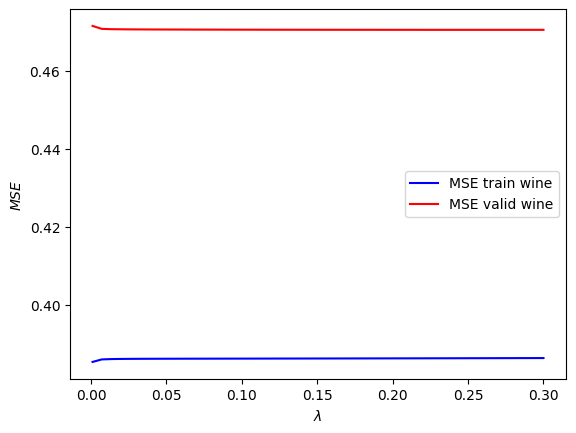

In [ ]:
#représenter ceci dans un graph : avec x = les valeurs de lambda et y = les valeurs de MSE
fig_wine, ax_wine = plt.subplots()
ax_wine.plot(hyp_lambdas_wine, train_mse_means_wine, c="blue", label="MSE train wine")
ax_wine.plot(hyp_lambdas_wine, val_mse_means_wine, c="red", label="MSE valid wine")
ax_wine.set_xlabel("$\lambda$")
ax_wine.set_ylabel("$MSE$")
ax_wine.legend()
plt.plot()

In [ ]:
#trouver la valeur optimale de lambda
index_opt_hyp_lambda_wine = np.where(val_mse_means_wine == min(val_mse_means_wine))[0][0]
opt_hyp_lambda_wine = float(hyp_lambdas_wine[index_opt_hyp_lambda_wine])
print(f"La valeur optimale de lambda est : {opt_hyp_lambda_wine}")

La valeur optimale de lambda est : 0.2694897959183673


In [ ]:
# On entraine le modèle sur toutes les données d'entrainement - validation
opt_lasso_reg_wine = Ridge(alpha=opt_hyp_lambda_wine)
opt_lasso_reg_wine.fit(inputs_train_wine_val, outputs_train_wine_val)
# On calcul l'erreur
test_mse_lasso_wine = np.mean((opt_lasso_reg_wine.predict(inputs_test_wine) - outputs_test_wine)**2)
test_mse_lasso_wine

0.48341696723580385

In [ ]:
#comparons avec une régression linéaire classique
# On entraine le modèle sur toutes les données d'entrainement - validation
lin_reg_wine = LinearRegression()
lin_reg_wine.fit(inputs_train_wine_val, outputs_train_wine_val)
# On calcul l'erreur
test_mse_lin_wine = np.mean((lin_reg_wine.predict(inputs_test_wine) - outputs_test_wine)**2)
test_mse_lin_wine

0.4854540109354198

Votre but sera de trouver un "bon" modèle pour prédire la variable **quality** en fonction des autres. Nous allons considérer les modèles de la famille **régression Ridge**. Il vous faudra :

1. Séparer le jeu de données en train/validation et test (20% pour test).
2. Faire une cross-validation (5-folds) sur train/validation à la recherche de l'hyperparamètre $\lambda$ minimisant la $MSE$ (parmi les valeurs allant de 0 à 0.3, à vous de voir le nombre d'étapes).
3. Tracer le graphique des $MSE_\text{train}$ et $MSE_\text{valid}$.
4. Trouver l'hyperparamètre optimal et estimer la perte de généralisation.

A vous de jouer !